In [74]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import np_utils
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification

In [75]:
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [76]:
import pathlib
data_dir = pathlib.WindowsPath("./train/")
data_dir=pathlib.Path(data_dir)

In [77]:
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3620


In [78]:
green = list(data_dir.glob('green/*'))
green_arrow = list(data_dir.glob('green_arrow/*'))
none = list(data_dir.glob('none/*'))
red = list(data_dir.glob('red/*'))
red_arrow = list(data_dir.glob('red_arrow/*'))
yellow = list(data_dir.glob('yellow/*'))
yellow_arrow = list(data_dir.glob('yellow_arrow/*'))

In [79]:
print("green")
print(len(green))
print("green arrow")
print(len(green_arrow))
print("none")
print(len(none))
print("red")
print(len(red))
print("red_arrow")
print(len(red_arrow))
print("yellow")
print(len(yellow))
print("yellow arrow")
print(len(yellow_arrow))

green
891
green arrow
254
none
794
red
1439
red_arrow
85
yellow
123
yellow arrow
34


In [80]:
batch_size = 10
img_height = 100
img_width = 50
epochs_to_run = 20

In [81]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3620 files belonging to 7 classes.
Using 2896 files for training.


In [82]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3620 files belonging to 7 classes.
Using 724 files for validation.


In [83]:
class_names = train_ds.class_names
print(class_names)

['green', 'green_arrow', 'none', 'red', 'red_arrow', 'yellow', 'yellow_arrow']


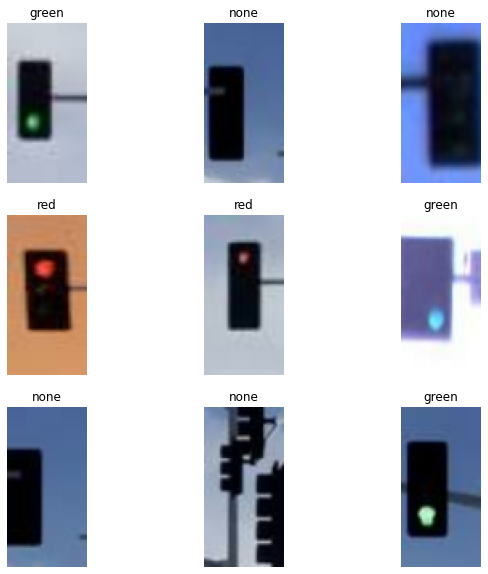

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [85]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 100, 50, 3)
(10,)


In [86]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [87]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
num_classes = len(class_names)

In [89]:
#creating a new model
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
model = tf.keras.Sequential([
    #layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
#loading a model
#model = tf.keras.models.load_model("./step_model_350")
#model.summary()

In [90]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss='binary_crossentropy',
    metrics=['accuracy']
)

In [91]:
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=epochs_to_run,
)

Epoch 1/20
290/290 [==============================] - 7s 26ms/step - loss: 1.9653 - accuracy: 0.8056 - val_loss: 0.2821 - val_accuracy: 0.9227
Epoch 2/20
290/290 [==============================] - 7s 23ms/step - loss: 0.1726 - accuracy: 0.9454 - val_loss: 0.1532 - val_accuracy: 0.9627
Epoch 3/20
290/290 [==============================] - 7s 23ms/step - loss: 0.1013 - accuracy: 0.9700 - val_loss: 0.2090 - val_accuracy: 0.9461
Epoch 4/20
290/290 [==============================] - 7s 23ms/step - loss: 0.0998 - accuracy: 0.9710 - val_loss: 0.1941 - val_accuracy: 0.9599
Epoch 5/20
290/290 [==============================] - 7s 23ms/step - loss: 0.0879 - accuracy: 0.9727 - val_loss: 0.2426 - val_accuracy: 0.9434
Epoch 6/20
290/290 [==============================] - 7s 23ms/step - loss: 0.1093 - accuracy: 0.9689 - val_loss: 0.1465 - val_accuracy: 0.9682
Epoch 7/20
290/290 [==============================] - 7s 23ms/step - loss: 0.0677 - accuracy: 0.9831 - val_loss: 0.2977 - val_accuracy: 0.9517

In [92]:
model.save("./test_model_020")
print("Saved New Model")

INFO:tensorflow:Assets written to: ./test_model_020\assets
Saved New Model


In [93]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

In [94]:
#get AUC ROC data
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

ValueError: in user code:

    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Austin Offill\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [32, 20]


In [95]:
model = tf.keras.models.load_model("./test_model_020")
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss='binary_crossentropy',
    metrics=['accuracy']
)
model.save("./test_model_020.h5", save_format='h5')

In [97]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 48, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 11, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 9, 32)         9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 4, 32)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)             